In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
from pathlib import Path
import glob
import os
import os.path

In [3]:
path = Path('flowers')

images = list(path.glob(r'*/*.jpg'))

labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1],images))

In [4]:
images_series = pd.Series(images,name='image_path').astype(str)
labels_series = pd.Series(labels,name='labels')

In [5]:
data = pd.concat([images_series,labels_series],axis=1)

In [6]:
data = data.sample(frac=1).reset_index(drop=True)

,image_path,labels
0,flowers\dandelion\33850973214_c1b4000d9c_n.jpg,dandelion
1,flowers\rose\9300754115_dd79670066_n.jpg,rose
2,flowers\tulip\20133942640_0f4442b858_n.jpg,tulip
3,flowers\daisy\20948886919_cac7844f34_n.jpg,daisy
4,flowers\rose\12323085443_8ac0cdb713_n.jpg,rose
...,...,...
4312,flowers\daisy\33859244503_eeeca6a397_n.jpg,daisy
4313,flowers\dandelion\13807932364_673b7f1c1c_n.jpg,dandelion
4314,flowers\tulip\12916135413_dafcf3089e_n.jpg,tulip
4315,flowers\daisy\2365428551_39f83f10bf_n.jpg,daisy


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train , X_test = train_test_split(data,test_size=0.2,shuffle=True,stratify=data.labels,random_state=17)
print(X_train.shape,X_test.shape)

((3453, 2), (864, 2))

In [9]:
import seaborn as sns

<AxesSubplot:xlabel='labels', ylabel='count'>

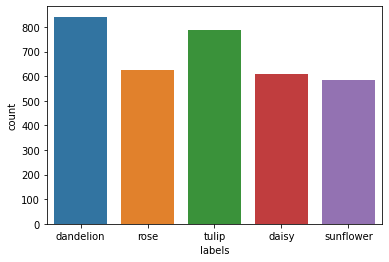

In [11]:
sns.countplot(data=X_train,x=X_train['labels'])

<AxesSubplot:xlabel='labels', ylabel='count'>

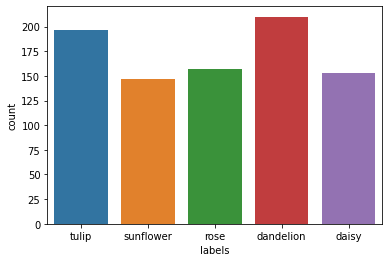

In [12]:
sns.countplot(data=X_test,x=X_test['labels'])

In [10]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale = 1.0/255,
        shear_range = 0.3,
        zoom_range = 0.3,
        horizontal_flip = True,
        vertical_flip = True,
        rotation_range = 45,
        brightness_range = [0.5,1],
        width_shift_range=0.1,
        height_shift_range=0.1
)

test_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale = 1.0/255,
        validation_split = 0.4
)

In [11]:
train_data = train_datagen.flow_from_dataframe(
        dataframe = X_train,
        x_col = 'image_path',
        y_col = 'labels',
        batch_size = 64,
        target_size = (150,150),
        class_mode = 'categorical',
        color_mode = 'rgb',
        subset='training'
)

test_data = test_datagen.flow_from_dataframe(
    dataframe = X_test,
    x_col = 'image_path',
    y_col = 'labels',
    batch_size = 64,
    target_size = (150,150),
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=False
)

val_data = test_datagen.flow_from_dataframe(
    dataframe = X_test,
    x_col = 'image_path',
    y_col = 'labels',
    batch_size = 64,
    target_size = (150,150),
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset = 'validation'
)

Found 3453 validated image filenames belonging to 5 classes.
Found 864 validated image filenames belonging to 5 classes.
Found 345 validated image filenames belonging to 5 classes.


In [12]:
opti = keras.optimizers.Adam(learning_rate=0.001)
def my_learning_rate(epoch, lrate):
    if epoch%7 == 0 and epoch!=0:
        lrate = lrate * 0.2
    return lrate
 
lrs = keras.callbacks.LearningRateScheduler(my_learning_rate)

In [13]:
model = keras.Sequential([
    keras.layers.Conv2D(16,(3,3),activation='relu',padding='same',input_shape=(150,150,3)),
    keras.layers.Conv2D(16,(3,3),activation='relu',padding='same'),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    keras.layers.MaxPooling2D(2,2),
    
    
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(320,activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(5,activation = 'softmax')
])

model.compile(optimizer = opti,loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 64)        1

In [14]:
cnn_model = model.fit(train_data,epochs=50,steps_per_epoch=54,validation_data=val_data,validation_steps=6,callbacks=[lrs])

Epoch 1/50
54/54 [==============================] - 35s 405ms/step - loss: 1.6044 - accuracy: 0.2381 - val_loss: 1.5980 - val_accuracy: 0.2435
Epoch 2/50
54/54 [==============================] - 17s 306ms/step - loss: 1.5997 - accuracy: 0.2349 - val_loss: 1.5975 - val_accuracy: 0.2435
Epoch 3/50
54/54 [==============================] - 17s 312ms/step - loss: 1.5968 - accuracy: 0.2389 - val_loss: 1.5865 - val_accuracy: 0.3101
Epoch 4/50
54/54 [==============================] - 17s 305ms/step - loss: 1.5523 - accuracy: 0.2858 - val_loss: 1.5083 - val_accuracy: 0.3275
Epoch 5/50
54/54 [==============================] - 17s 311ms/step - loss: 1.4203 - accuracy: 0.3611 - val_loss: 1.4803 - val_accuracy: 0.3391
Epoch 6/50
54/54 [==============================] - 19s 355ms/step - loss: 1.3141 - accuracy: 0.4078 - val_loss: 1.3837 - val_accuracy: 0.4203
Epoch 7/50
54/54 [==============================] - 17s 314ms/step - loss: 1.2256 - accuracy: 0.4732 - val_loss: 1.3046 - val_accuracy: 0.4000

In [16]:
model.save('scratch_cnn')

INFO:tensorflow:Assets written to: 5_layer_cnn\assets


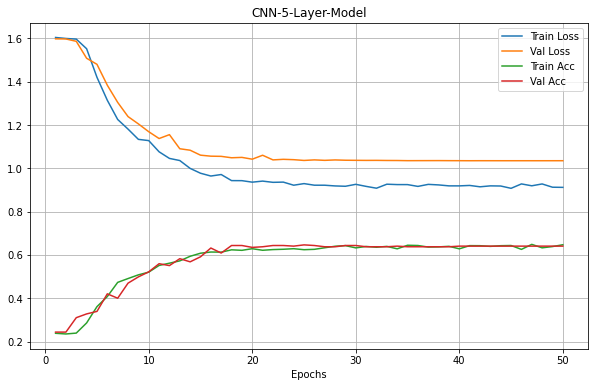

In [18]:
epochs = range(1, 51)
plt.figure(figsize=(10,6))
plt.plot(epochs, cnn_model.history['loss'], label='Train Loss')
plt.plot(epochs, cnn_model.history['val_loss'], label='Val Loss')
plt.plot(epochs, cnn_model.history['accuracy'], label='Train Acc')
plt.plot(epochs, cnn_model.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.title('CNN-5-Layer-Model')
plt.grid()
plt.legend()

plt.savefig('cnn_5_layer.jpg',dpi=500)
plt.show()